# PDE 3 Workshop 2

Welcome to the second workshop of the PDE 3 (Numerical) course!

## In this workshop:
- Jacobi Iteration
- Bonus Section 1: Successive Over-Relaxation - see the additional Jupyter notebook
- Bonus Section 2: Comparing Analytical and Numerical Solutions - see the additional Jupyter notebook

In [1]:
# Run this cell to import the required modules.
# Do this before you write any code!
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

# Section 1: Jacobi Iteration

In this section, we will use the Jacobi Iteration scheme to solve the Laplace equation. 

The Jacobi Iteration scheme is based on the second order finite difference approximations
$$
\dfrac{\partial^2u}{\partial x^2} = \dfrac{u_{i-1,j}-2u_{i,j}+u_{i+1,j}}{(\Delta x)^2}
$$

$$
\dfrac{\partial^2u}{\partial y^2} = \dfrac{u_{i,j-1}-2u_{i,j}+u_{i,j+1}}{(\Delta y)^2}
$$

which we can use to determine scheme for the Jacobi iteration (see lecture 2 for further details):

$$
u_O = \dfrac{1}{2(1+\beta^2)}(u_E + u_W + \beta^2 (u_N +u_S))
$$
where $\beta=\frac{\Delta x}{\Delta y}$ is the ratio of the mesh spacing in the $x$ and $y$ directions.

By successively applying this formula to all the interior points of the grid, we can solve the Laplace equation.

<div>
<img src="jacobi.svg" width="500"/>
</div>

### Pseudocode

The steps required for the Jacobi iteration can be written as the following pseudocode.

1. Specify the initial values $u_{i,j}^0$ for all $x_i$,$y_j$
2. Set the iteration counter $m=0$
4. Repeat:

    1. Apply the boundary conditions
    2. Compute $u_{i,j}^{m+1} = \dfrac{1}{2(1+\beta^2)}(u_{i+1,j}^m + u_{i-1,j}^m + \beta^2 (u_{i,j+1} ^m+u_{i,j-1}^m))$ for all $x_i$, $y_j$
    3. Increment $m$
    
5. Stop when $max|u_{i,j}^{m-1}-u_{i,j}^m|<$ tolerance or $m > m_{max}$


### a)

Define a function `u_O(u_E, u_W, u_N, u_S, delta_x, delta_y)` below to calculate $u_0$ given the neighbouring values and the desired grid spacing. This is step 3.2 in our pseudocode.

In [2]:
# Your code here

### BEGIN SOLUTION ###

def u_O(u_E: float, u_W: float, u_N: float, u_S: float, delta_x: float = 1., delta_y: float = 1.) -> float:
    """The Jacobi iteration for the initial guess of the solution."""
    beta = delta_x / delta_y
    return (u_E + u_W + beta**2 * (u_N + u_S)) / (2 * (1 + beta**2))
    
### END SOLUTION ###

In [3]:
### BEGIN TESTS ###

assert type(u_O(0, 0, 0, 0, 1, 1)) == float, """Check to ensure that u_O returns a float when only single values are passed into it."""
assert u_O(0, 0, 0, 0, 1, 1) == 0, """Check to ensure that you have implemented u_O correctly using the definition above."""
assert u_O(1, 1, 1, 1, 1, 1) == 1, """Check to ensure that you have implemented u_O correctly using the definition above."""

### END TESTS ###

In the rest of this question, we will solve the Laplace equation for the steady-state heat distribution $u(x,y)$ on a square metal plate which is 30 cm x 30 cm in size.

The boundary conditions of the system are as follows:

* The bottom side is held at $0^\circ C$
* The top side is heated so that the left corner is at $0^\circ C$ and the right corner is at $100^\circ C$, and the temperature varies linearly between these two points
* The left side is insulated
* The right side insulated


Mathematically, we can write these as:

* $u(x,0) = 0^\circ C$ 

* $u(x,1) = \frac{x}{30} \times 100^\circ C$

* $\left.\dfrac{\partial u}{\partial x}\right|_{x=0} = 0$

* $\left.\dfrac{\partial u}{\partial x}\right|_{x=1} = 0$

The first two of these boundary conditions are Dirichlet boundary conditions, whereas the last two are Neumann boundary conditions.

### b)
Describe the differences between Neumann and Dirichlet boundary conditions and how they can be implemented in the Jacobi Iteration scheme.

<font color='orange'>Your answer goes here. Double-click the cell to modify it.</font>

<font color='red'>

### Solution:

For Dirichlet boundary conditions, we can set the boundary value when we initialise the grid and keep it fixed throughout the iterations. Neumann boundary conditions, on the other hand, are defined in terms of the derivative of the solution at the boundary. For example, for the right side, we need to update the boundary values at each iteration for the current values of the mesh according to
$$
u_{i+1,j} = u_{i-1,j} + 2\Delta x a,
$$
where $a$ is the specified Neumann boundary condition ($a=0$ in this problem). A similar equation can be written for the Neumann boundary condition on the left side of the computational domain.


### Provided for you: The Grid class

To implement Jacobi iteration scheme in code, we will need a grid of points to iterate over. Below is a `Grid` class which we can use. You don't need to know all of the details (though feel free to look through the code if you would like to!) but it has a number of useful methods and variables built in:
- `Grid.x`: The $x$ values of the grid
- `Grid.y`: The $y$ values of the grid
- `Grid.u`: The current values of $u_{i,j}$ on the grid
- `Grid.generate()`: A method (function) to generate the actual grid of points
- `Grid.update()`: A method to update the values of $u_{i,j}$ on the grid
- `Grid.Delta_x()`: A method to calculate $\Delta x$
- `Grid.Delta_y()`: A method to calculate $\Delta y$

To create a variable of type ``Grid``, which is named `mesh`, you can use the following syntax:

```python
mesh = Grid(ni,nj)
```

where ``ni`` and ``nj`` are the number of nodes in the x and y directions respectively.
The properties and methods of the grid class can be accessed using the ``.`` operator, for example:

```python
mesh.u
mesh.Delta_x()
```

Run the cell below to implement the ``Grid`` class and continue.

In [4]:
class Grid:
    """A class defining a 2D grid on which we can implement the Jacobi and SOR iteration schemes."""

    def __init__(self, ni: int, nj: int):
        self.ni = ni
        self.nj = nj
        self.origin = (0.0, 0.0)
        self.extent = (1.0, 1.0)

        self.u = np.zeros((ni, nj))
        self.x = np.zeros((ni, nj))
        self.y = np.zeros((ni, nj))
    
    def set_origin(self, x0: float, y0: float):
        """Set the origin of the grid."""
        self.origin = (x0, y0)

    def set_extent(self, x1: float, y1: float):
        """Set the extent of the grid."""
        self.extent = (x1, y1)

    def Delta_x(self) -> float:
        """The spacing in the x-direction."""
        return (self.extent[0] - self.origin[0]) / (self.ni - 1)
    
    def Delta_y(self) -> float:
        """The spacing in the y-direction."""
        return (self.extent[1] - self.origin[1]) / (self.nj - 1)
    
    def generate(self, Quiet: bool = True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        x_ord = np.linspace(self.origin[0], self.extent[0], self.ni, endpoint=True)
        y_ord = np.linspace(self.origin[1], self.extent[1], self.nj, endpoint=True)
        self.x, self.y = np.meshgrid(x_ord,y_ord)
        self.x = np.transpose(self.x)
        self.y = np.transpose(self.y)

        if not Quiet:
            print(self)
    
    def __str__(self):
        """A quick function to tell us about the grid. This will be what is displayed if you try to print the Grid object."""
        return f"Grid Object: Uniform {self.ni}x{self.nj} grid from {self.origin} to {self.extent}."


### c)

Write a function called ``NeumannBC`` which takes in a `Grid` object called `mesh` and `float` called ``a``, the value of the Neumann boundary condition, and implements the Neumann boundary conditions as defined above using the central difference scheme.
Since you will be be updating ``mesh`` directly, you do not need to return anything from the function.

In [5]:
# Your code here

### BEGIN SOLUTION ###
def NeumannBC(mesh: Grid, a: float = 0) -> None:
    """Set the Neumann boundary conditions on the mesh.
    
    Parameters:
    -----------
    mesh: Grid
        The mesh on which to set the boundary conditions.
        
    a: float
        The value of the Neumann boundary condition.
        It is assumed that both the left and right boundaries have the same value.
    """
    mesh.u[0, :] = mesh.u[2, :] - 2*mesh.Delta_x()*a
    mesh.u[-1, :] = mesh.u[-3, :] + 2*mesh.Delta_x()*a

### END SOLUTION ###

In [6]:
### BEGIN TESTS ###
test_grid = Grid(4,4)
test_grid.generate()
NeumannBC(mesh = test_grid, a = 0)
assert np.isclose(test_grid.u, np.zeros((4,4))).all(), """If all of the interior points of the grid are zero, then the Neumann boundary conditions should also be zero."""

NeumannBC(mesh = test_grid, a = 1)
assert np.isclose(test_grid.u[0], np.array([-0.666667]*4)).all() and np.isclose(test_grid.u[-1], np.array([0.666667]*4)).all(), """Check to ensure that you have accounted for the value of `a` correctly."""

test_grid.u[1] = np.array([1,1,1,1])
test_grid.u[2] = np.array([2,2,2,2])
NeumannBC(mesh = test_grid, a = 0)
assert not np.isclose(test_grid.u[0], np.array([1,1,1,1])).all() and not np.isclose(test_grid.u[-1], np.array([2,2,2,2])).all(), """You appear to have used the backward difference method for the Neumann boundary conditions. Ensure you use the central difference method."""
assert np.isclose(test_grid.u[0], np.array([2,2,2,2])).all() and np.isclose(test_grid.u[-1], np.array([1,1,1,1])).all(), """Ensure you have used the central difference method to calculate the Neumann boundary conditions."""
### END TESTS ###

### Provided for you: The Jacobi function

Below, we implement the Jacobi iterative scheme to solve the Laplace equation for our system.
This implements the psudocode above and uses the functions you have defined.

The function `Jacobi` takes four inputs: the mesh (a ``Grid`` object), the maximum number of iterations, the tolerance criterion and the Neumann boundary condition. 
The iteration stops when the number of iterations exceeds the maximum number specified or if it meets the tolerance criterion. For simplicity, the latter is calculated as the maximum difference in any grid point between the old and new values.
The function outputs the number of iterations when the solution converges below the tolerance criterion, and the error at the last iteration.

The iterative scheme is implemented twice, once using `for` loops (which is easier to understand) and once using numpy array operations (which is faster). You can compare the two implementations by uncommenting the relavent lines below.

In [7]:
# This function is given for you. You do not need to modify it.
# Run this cell to continue.
def Jacobi(mesh: Grid, max_iterations: int, tolerance: float, neumann:float) -> tuple[int, float]:
    """The Jacobi iteration scheme.
    
    Parameters:
    -----------

    mesh: Grid
        The grid on which to implement the Jacobi iteration.
    max_iterations: int
        The maximum number of iterations to perform.
    tolerance: float
        The error tolerance.
    neumann: float
        The Neumann boundary condition.
        Note that in this code, all Neumann boundary conditions are assumed to be the same.
        
    Returns:
    --------
    
    n_iterations: int
        The number of iterations performed.
    error: float
        The error in the solution.
    """

    n_iterations = 0

    u_new = mesh.u.copy()
    while n_iterations < max_iterations:
        # Implement the Neumann boundary conditions.
        NeumannBC(mesh = mesh, a = neumann)

        # Do the iteration
        for i in range(1, mesh.ni-1): # Comment out this line to try array operations
            for j in range(1, mesh.nj-1): # Comment out this line to try array operations
                u_new[i, j] = u_O(mesh.u[i+1, j], mesh.u[i-1, j], mesh.u[i, j+1], mesh.u[i, j-1], mesh.Delta_x(), mesh.Delta_y()) # Comment out this line to try array operations
        # Note that we can also do use array operations to complete the iteration, as done below. 
        # #Typically, this is MUCH faster than using for loops. 
        # #Comment out the three lines of code above and uncomment the line below to try it out.
        # u_new[1:-1, 1:-1] = u_O(mesh.u[2:, 1:-1], mesh.u[:-2, 1:-1], mesh.u[1:-1, 2:], mesh.u[1:-1, :-2], mesh.Delta_x(), mesh.Delta_y()) # Uncomment this line to try array operations
        
        # Implement the Dirichlet boundary conditions.
        u_new[0,:] = mesh.u[0,:]
        u_new[-1,:] = mesh.u[-1,:]
        
        # A tolerance criterion to stop the iteration if the solution has converged.
        error = np.max(abs(mesh.u-u_new))
        if error < tolerance:
            mesh.u = u_new.copy()
            break
        mesh.u = u_new.copy()
        
        n_iterations += 1

    if n_iterations == max_iterations:
        print(f"Jacobi iteration has not converged after {n_iterations} iterations.\nThe error is {np.max(error)}.")

    return n_iterations, error

### Provided for you: Initialisation of the problem

In the cell below, we define a function `set_Jacobi_mesh` to setup the mesh and implement the Dirichlet boundary conditions given at the start of the section. This essentially covers step 1 of our pseudocode. Try to understand this code, as you will need something similar in future workshops. Run this cell, then move on to the next part. 

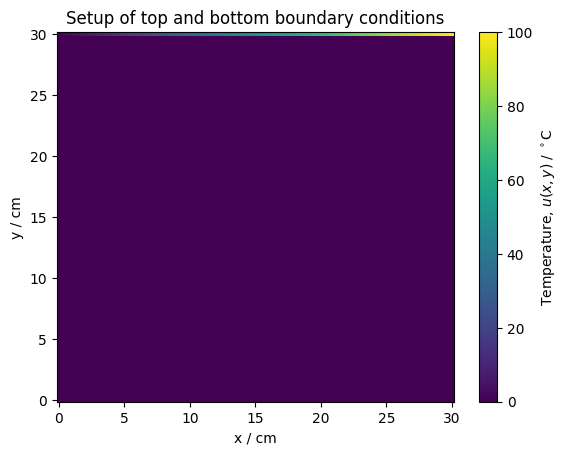

In [8]:
def set_Jacobi_mesh() -> Grid:
    """Set up the Jacobi mesh for the problem."""
    Jacobi_mesh = Grid(101,101) # Sets the size of the grid in terms of grid points.
    Jacobi_mesh.set_extent(30.,30.) # Sets the extent of the grid in terms of physical units.
    Jacobi_mesh.set_origin(0., 0.) # Sets the origin of the grid in terms of physical units.
    Jacobi_mesh.generate() # Generates the x, y and u arrays for the grid.


    # Implement the Dirichlet boundary conditions
    Jacobi_mesh.u[:,0] = 0
    Jacobi_mesh.u[:,-1] = 100/30*Jacobi_mesh.x[:,-1]
    return Jacobi_mesh

Jacobi_mesh = set_Jacobi_mesh()

# Plot the initial conditions

plt.pcolor(Jacobi_mesh.x, Jacobi_mesh.y, Jacobi_mesh.u)
cax = plt.colorbar()
plt.title("Setup of top and bottom boundary conditions")
plt.xlabel("x / cm")
plt.ylabel("y / cm")
cax.set_label(r"Temperature, $u(x,y)$ / $^\circ$C ")
plt.show()

### d)

Now, we will run the Jacobi iteration on the mesh defined above for two cases: one where the solution has not fully converged and one where it has.

**i)**

Set up the Jacobi mesh using the `set_Jacobi_mesh()` function and run the Jacobi iteration using the `Jacobi` function given above.

[Hint: In the first instance, set ``max_iterations`` to be very low so that this stops the iteration. Play around wih the ``max iterations`` so that you gain some insight into how the solution converges.]

In [9]:
# Your code here.

### BEGIN SOLUTION ###

# Initialise the mesh
Jacobi_mesh = set_Jacobi_mesh()
# Perform the iteration
n_iterations, error = Jacobi(mesh=Jacobi_mesh, max_iterations = 100, tolerance=1e-4, neumann=0)

### END SOLUTION ###

Jacobi iteration has not converged after 100 iterations.
The error is 0.2260041865479856.


**ii)**

Plot the results of the Jacobi iteration using [`plt.pcolor`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolor.html).

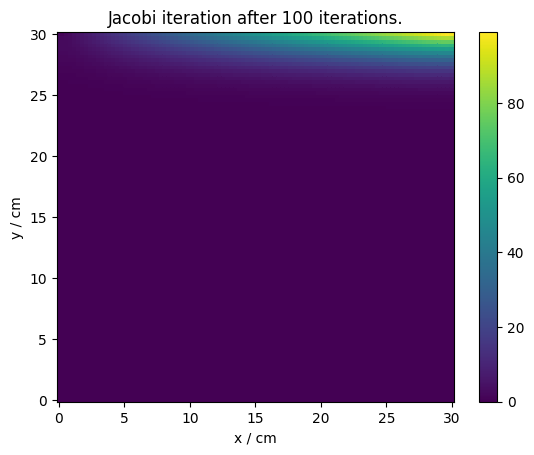

In [10]:
### BEGIN SOLUTION ###

plt.figure()
plt.pcolor(Jacobi_mesh.x, Jacobi_mesh.y, Jacobi_mesh.u)
plt.xlabel('x / cm')
plt.ylabel('y / cm')
plt.title(f"Jacobi iteration after {n_iterations} iterations.")
plt.colorbar()
plt.show()

### END SOLUTION ###

**iii)**

Repeat steps i) and ii) for the case where the solution has converged.

[Hint: Set ``max_iterations`` to be high enough to allow the iteration to converge.]

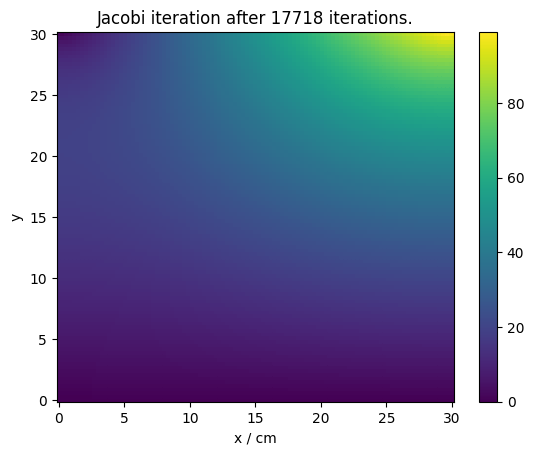

Jacobi iteration has not converged after 100 iterations.
The error is 0.2260041865479856.


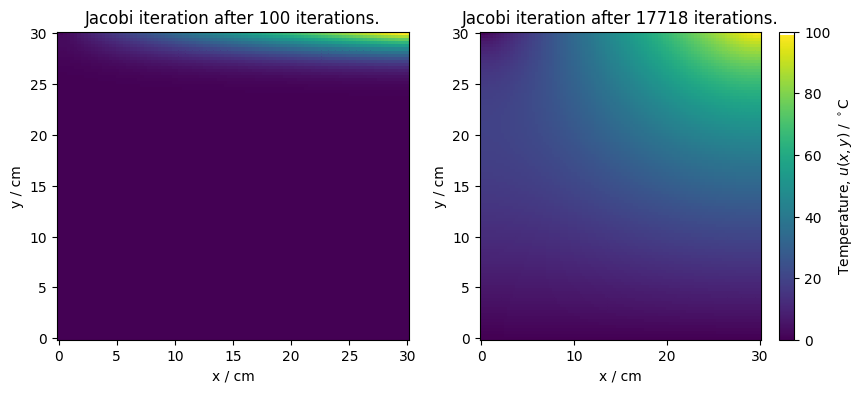

In [11]:
### BEGIN SOLUTION ###

# There are (at least) two ways that we can display our plots.
# The first is simpler while the second offers more flexability for more complex plots.
# We implement both below, starting with the simpler method, which is the same as above:


# Set up the mesh and run the iteration
Jacobi_mesh = set_Jacobi_mesh()
n_iterations, error = Jacobi(mesh=Jacobi_mesh, max_iterations = 100000, tolerance=1e-4, neumann=0)

# Plot the results
plt.figure()
plt.pcolor(Jacobi_mesh.x, Jacobi_mesh.y, Jacobi_mesh.u)
plt.xlabel('x / cm')
plt.ylabel('y')
plt.title(f"Jacobi iteration after {n_iterations} iterations.")
plt.colorbar()
plt.show()

# The second method is more complex but allows us to create more complex plots.
# Here, we iterate over the values for max_iterations and plot the results as subplots.

fig, ax = plt.subplots(1, 2, figsize=(10,4))
for i, it in enumerate([100,100000]):
    Jacobi_mesh = set_Jacobi_mesh()
    n_iterations, error = Jacobi(Jacobi_mesh, it, 1e-4, neumann=0)
    ax[i].pcolor(Jacobi_mesh.x, Jacobi_mesh.y, Jacobi_mesh.u)
    ax[i].set_xlabel('x / cm')
    ax[i].set_ylabel('y / cm')
    ax[i].set_title(f"Jacobi iteration after {n_iterations} iterations.")
cax = fig.colorbar(ax[i].collections[0], ax=ax[i])
cax.set_label(r"Temperature, $u(x,y)$ / $^\circ$C")
cax.set_ticks([20*i for i in range(6)])

plt.show()

### END SOLUTION ###

Once you have finished these questions, please move on to the bonus sections in the additional Jupyter notebook.